<a href="https://colab.research.google.com/github/cmosquera15/Entregas-Proyecto-Modelos-I-2025.2/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consideraciones antes de ejecutar el notebook


Se debe cambiar el entorno de ejecución para que el programa corra de manera correcta: clic en entorno de ejecucion -> cambiar tipo de entorno de ejecución -> se selecciona GPU T4 -> guardar.

* **Preprocesado FeatureEng+Nativo:** porque se creo variables nuevas.
* **Nativo:** porque NO se uso LabelEncoder ni OneHot; se dejo el texto crudo para que CatBoost lo leyera.
* **CatBoost:** Porque el modelo es solo CatBoost


# Instalación y Configuración


In [ ]:
# 1. Instalación de CatBoost
print("Instalando CatBoost...")
!pip install catboost -q

import os
import json
import gc # Garbage Collector para limpiar RAM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 2. Configuración de Credenciales
print("🔑 Configurando API de Kaggle...")
data = {"username":"josemiguelc1","key":"1a8778db87047d4dc2602b6e2395bf36"}
with open('kaggle.json','w') as f:
    json.dump(data, f)
!chmod 600 kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

# 3. Descarga de Datos
print("📥 Descargando dataset...")
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -p /content/ --force
!unzip -o -q udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

print("✅ Entorno GPU preparado y datos listos.")

Instalando CatBoost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
🔑 Configurando API de Kaggle...
📥 Descargando dataset...
  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.73GB/s]
✅ Entorno GPU preparado y datos listos.


#Carga y Exploración Inicial

 Train Shape: (692500, 21)
Test Shape:  (296786, 20)


/tmp/ipython-input-426901066.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=TARGET_COL, data=df_train, palette="viridis", order=df_train[TARGET_COL].value_counts().index)


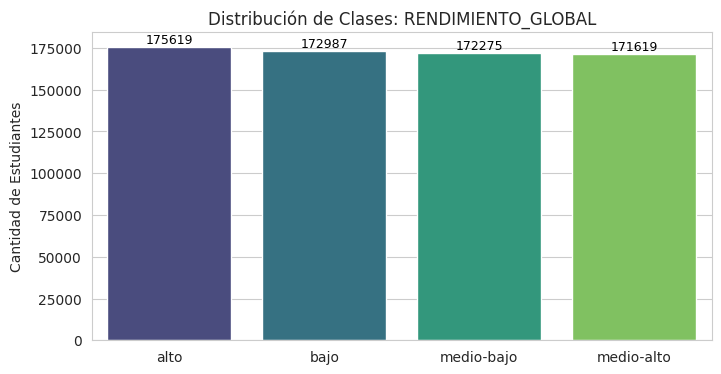

In [ ]:
# Cargar CSVs
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
TARGET_COL = 'RENDIMIENTO_GLOBAL'
ID_COL = 'ID'

print(f" Train Shape: {df_train.shape}")
print(f"Test Shape:  {df_test.shape}")

# Gráfica de distribución del Target
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=TARGET_COL, data=df_train, palette="viridis", order=df_train[TARGET_COL].value_counts().index)
plt.title(f'Distribución de Clases: {TARGET_COL}', fontsize=12)
plt.xlabel('')
plt.ylabel('Cantidad de Estudiantes')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

#Feature Engineering y Preprocesado Nativo

In [ ]:
print("Aplicando Ingeniería de Características...")

# Unimos todo para aplicar los cambios por igual
df_all = pd.concat([df_train.drop(columns=[TARGET_COL]), df_test], axis=0)

# --- 1. FEATURE ENGINEERING: SCORE DE PRIVILEGIOS ---
# Sumamos todo lo que empieza por "TIENE" (Internet, PC, etc.)
cols_tiene = [c for c in df_all.columns if 'TIENE' in c]
print(f"    Variables de posesiones detectadas: {len(cols_tiene)}")

# Convertimos 'Si'/'Yes' -> 1, 'No' -> 0
for col in cols_tiene:
    df_all[col] = df_all[col].astype(str).str.lower().map({'si': 1, 'yes': 1, 'no': 0}).fillna(0)

# Creamos la nueva columna
df_all['SCORE_PRIVILEGIOS'] = df_all[cols_tiene].sum(axis=1)
print("Variable 'SCORE_PRIVILEGIOS' creada.")

# --- 2. LIMPIEZA NATIVA (CATBOOST STRATEGY) ---
# Identificar columnas
categorical_cols = df_all.select_dtypes(include=['object']).columns.tolist()
if ID_COL in categorical_cols: categorical_cols.remove(ID_COL)

numeric_cols = df_all.select_dtypes(include=['int64', 'float64']).columns.tolist()
if ID_COL in numeric_cols: numeric_cols.remove(ID_COL)

print(f"    Categóricas: {len(categorical_cols)} | Numéricas: {len(numeric_cols)}")

# Rellenar nulos (Texto -> "Missing", Números -> -999)
for col in categorical_cols:
    df_all[col] = df_all[col].fillna("Missing").astype(str)
for col in numeric_cols:
    df_all[col] = df_all[col].fillna(-999)

# Separar de nuevo
X = df_all.iloc[:len(df_train)].drop(columns=[ID_COL], errors='ignore')
X_test_final = df_all.iloc[len(df_train):].drop(columns=[ID_COL], errors='ignore')
y = df_train[TARGET_COL]

# Codificar Target (Label Encoding necesario para métricas)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(" Datos preprocesados y listos para el entrenamiento.")
display(X.head(3))

Aplicando Ingeniería de Características...
    Variables de posesiones detectadas: 5
Variable 'SCORE_PRIVILEGIOS' creada.
    Categóricas: 9 | Numéricas: 11
 Datos preprocesados y listos para el entrenamiento.


,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,SCORE_PRIVILEGIOS
0,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,1.0,Técnica o tecnológica incompleta,1.0,1.0,N,No,1.0,1.0,Postgrado,0.322,0.208,0.310,0.267,5.0
1,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,0.0,Técnica o tecnológica completa,1.0,0.0,N,No,1.0,0.0,Técnica o tecnológica incompleta,0.311,0.215,0.292,0.264,2.0
2,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,1.0,Secundaria (Bachillerato) completa,1.0,0.0,N,No,0.0,1.0,Secundaria (Bachillerato) completa,0.297,0.214,0.305,0.264,3.0


#Entrenamiento Robusto (5-Fold CV + GPU)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

test_probs_sum = np.zeros((len(X_test_final), len(le.classes_)))
fold_scores = []

print(f"🚀 Iniciando Entrenamiento 5-Fold AGRESIVO en GPU (Sin RSM)...")

fold = 1
for train_idx, val_idx in skf.split(X, y_encoded):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # --- CONFIGURACIÓN AGRESIVA COMPATIBLE CON GPU ---
    model = CatBoostClassifier(
        iterations=3000,        # Subimos iteraciones para compensar
        learning_rate=0.035,
        depth=8,                # Potencia alta
        l2_leaf_reg=3,          # Poca regularización (Agresivo)

        # GPU CONFIG
        task_type="GPU",
        devices='0',

        # ACELERADORES COMPATIBLES CON GPU
        bootstrap_type='Bernoulli',
        subsample=0.6,          # Esto SÍ funciona en GPU y acelera
        # Quitamos 'colsample_bylevel' porque es lo que daba error

        cat_features=categorical_cols,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        random_seed=42,
        verbose=0,
        early_stopping_rounds=150
    )

    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

    val_preds = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, val_preds)
    fold_scores.append(acc)

    test_probs_sum += model.predict_proba(X_test_final)

    print(f"   🔥 Fold {fold}/{N_FOLDS} | Accuracy: {acc:.4f}")

    del model, X_train_fold, X_val_fold
    gc.collect()
    fold += 1

print(f"\n🏆 Promedio Final en Validación: {np.mean(fold_scores):.4f}")

🚀 Iniciando Entrenamiento 5-Fold AGRESIVO en GPU (Sin RSM)...
   🔥 Fold 1/5 | Accuracy: 0.4330
   🔥 Fold 2/5 | Accuracy: 0.4321
   🔥 Fold 3/5 | Accuracy: 0.4294
   🔥 Fold 4/5 | Accuracy: 0.4328
   🔥 Fold 5/5 | Accuracy: 0.4321

🏆 Promedio Final en Validación: 0.4319


#Importancia de Variables (Visual)

/tmp/ipython-input-2797586715.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df, palette='rocket')


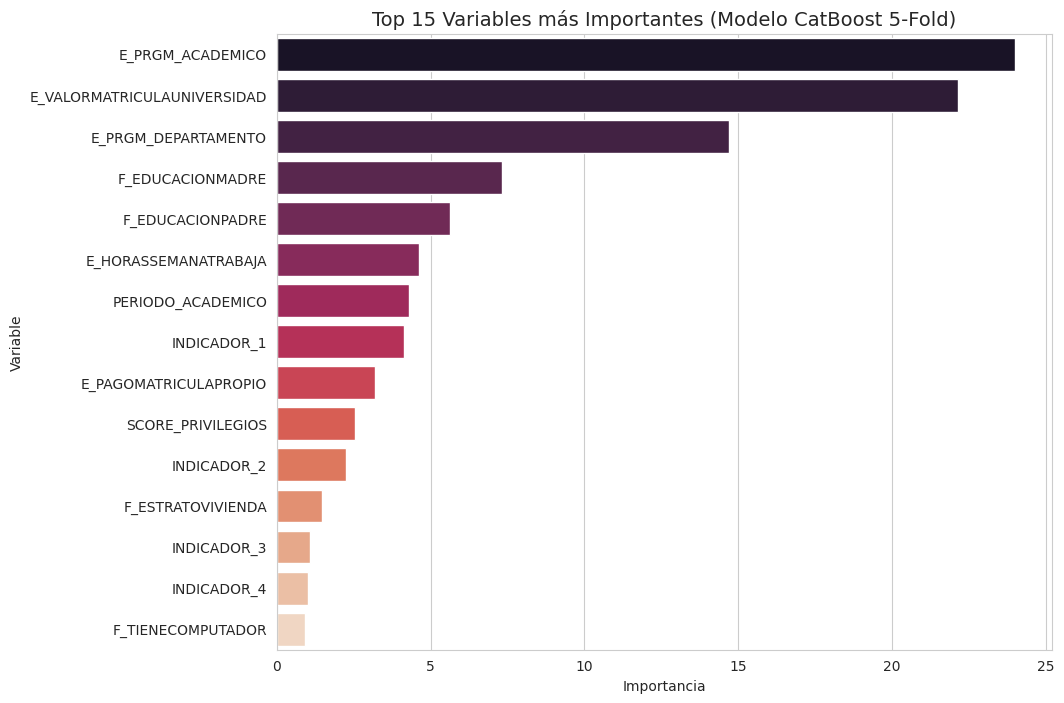

👀 Nota: Busca si 'SCORE_PRIVILEGIOS' aparece en la lista.


In [ ]:
# Crear DataFrame de importancia
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df = fi_df.sort_values('importance', ascending=False).head(15)

# Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=fi_df, palette='rocket')
plt.title('Top 15 Variables más Importantes (Modelo CatBoost 5-Fold)', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

print("👀 Nota: Busca si 'SCORE_PRIVILEGIOS' aparece en la lista.")

#Generación de Entrega y Envío

In [ ]:
print("Calculando promedio de los 5 modelos...")

# Promediamos las probabilidades acumuladas
avg_probs = test_probs_sum / N_FOLDS

# Elegimos la clase ganadora
final_preds_indices = np.argmax(avg_probs, axis=1)
final_preds_texto = le.inverse_transform(final_preds_indices)

# Recuperar IDs
if ID_COL in df_test.columns:
    test_ids = df_test[ID_COL]
else:
    test_ids = df_test.index

# Crear DataFrame
submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET_COL: final_preds_texto
})

# Guardar
out_filename = "submission_05_CatBoost_5Fold_GPU.csv"
submission.to_csv(out_filename, index=False)

print("\n--- Previsualización del Archivo Final ---")
display(submission.head())

# Subir a Kaggle
print("\n Subiendo a Kaggle...")
message = "Notebook 05 - CatBoost 5Fold GPU + FeatureEng"
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f {out_filename} -m "{message}"

print(" ¡Proceso finalizado! Revisa tu Leaderboard.")

Calculando promedio de los 5 modelos...

--- Previsualización del Archivo Final ---


,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo



 Subiendo a Kaggle...
100% 4.06M/4.06M [00:00<00:00, 17.1MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia ¡Proceso finalizado! Revisa tu Leaderboard.
